# Mini proyecto 4
## Sistema de recomendación de películas 🎬
## Made with 💖 by:
## -Acosta Imandt Daniel
## -Callejas Hérnandez Edgar
## -Garduño Mártinez Eduardo


Estaos interesados en crear sistemas de recomendación de peliculas dados los datos que se pueden encontrar en esta liga (https://grouplens.org/datasets/movielens/1m/) la cual es una base de datos de los ratings que le dieron diferentes usuarios(6040) a peliculas (3883).

Es decir queremos proponer un conjunto de sugerencias útiles para el usuario.
Para esto vamos a utilizar dos técnicas diferentes.
- Primero vamos a ver los géneros de las peliculas que tenemos en la base de datos y los vamos a mapear en un espacio $n-$dimensional,  donde $n=18$ es el número de géneros totlaes en la base de datos. Por otro lado vamos a juntar todas las peliculas que ha visto cada usuario y vamos a sumar todos los géneros que suele ver  dandole cierto peso a las calificaciones de esas peliculas.Por ultimo vamos a poner a cada usuario en ese espacio $n$-dimensional y encontrar la pelicula más cercana a este usurio.
- La segunda técnica que vamos autilizar es el modelo de factor latente, esta es utilizando los ratings de los usarios para poder inferir patrones de productos y usuarios, para esto se utilizan los vectores latentes, utilizando valores singulares (SVD). Esto lo hacemos para poder estimar los datos ausentes, es decir las peliculas que no tienen ningún rating por los usuarios, pero encotramos ciertas correlaciones entre usuarios y darle un rating previsto a estas peliculas gracias a las dadas por otros.

In [1]:
#Cargamos líbrerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly as ply
import plotly.express as px
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
!pip install scikit-surprise
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
sns.set_style("darkgrid")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Carga de los datos

In [111]:
# Cargamos las bases de datos
#Base de datos de las peliculas
movies= pd.read_csv('/content/movies.dat', 
                 sep="::", 
                 names=['movie_id','title','genres']
                 ,encoding='latin-1')
#base de datos de los usuarios
users = pd.read_csv('/content/users.dat', 
                 sep="::", 
                 names=['id','genero','edad','ocupacion','zip-code'])

#base de datos de las raitings
ratings=pd.read_csv('/content/ratings.dat',sep='::', names=['UserID','MovieID','Rating','Timestamp'])
#base de datos del usuario dafelisioso
daf=pd.read_csv('/content/ratings.csv')


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



## limpieza de los datos exploratorio de los datos

In [ ]:
daf['title']=daf["Name"] +' ('+ daf["Year"].astype(str) +')'

In [112]:
ratings=ratings.drop(['Timestamp'], axis=1) #eliminamos columnas que no nos interesanratings.tail()
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [113]:
daf.head()

,Date,Name,Year,Letterboxd URI,Rating,title
0,2020-11-20,The Queen's Gambit,2020,https://boxd.it/s1Ym,4.0,The Queen's Gambit (2020)
1,2020-11-20,Parasite,2019,https://boxd.it/hTha,5.0,Parasite (2019)
2,2020-11-20,The Trial of the Chicago 7,2020,https://boxd.it/kn3w,4.0,The Trial of the Chicago 7 (2020)
3,2020-11-20,Spider-Man: Into the Spider-Verse,2018,https://boxd.it/azpY,4.0,Spider-Man: Into the Spider-Verse (2018)
4,2020-11-20,Knives Out,2019,https://boxd.it/jWEA,4.0,Knives Out (2019)


In [114]:
mov=movies.merge(daf,left_on='title',right_on='title')
mov['UserID']=0
mov=mov.drop(['genres','Date','Name','Year','Letterboxd URI','title'], axis=1) #eliminamos columnas que no nos interesan
mov.rename(columns = {'movie_id':'MovieID'}, inplace = True)
mov = mov[['UserID',	'MovieID'	,'Rating']]

mov=pd.concat([mov,ratings]).reset_index(drop=True)
mov.head()

,UserID,MovieID,Rating
0,0,101,3.0
1,0,123,4.5
2,0,215,5.0
3,0,296,5.0
4,0,307,3.5


## Análisis exploratorio de los datos

In [115]:
px.bar(ratings['Rating'].value_counts(),title="Calificaciones totales").update_layout(xaxis_title="Rating", yaxis_title="Frecuencia",showlegend=False)



In [116]:

px.bar(daf['Rating'].value_counts(),title="Calificaciones de dafelisioso",).update_layout(xaxis_title="Rating", yaxis_title="Frecuencia",showlegend=False)

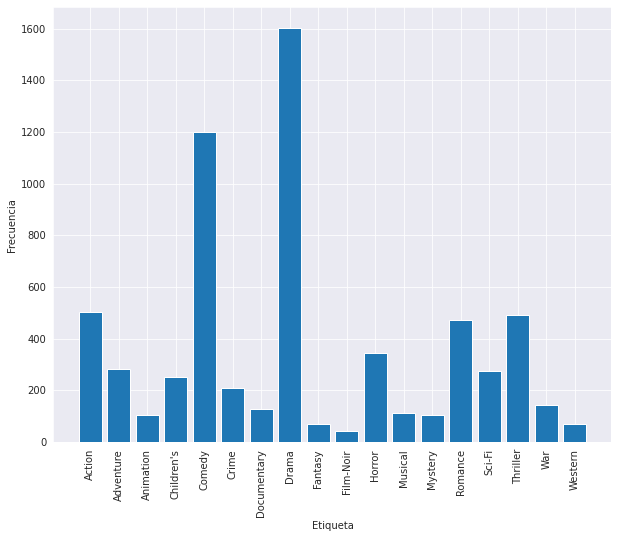

In [61]:
s1=pd.get_dummies(movies['genres'].apply(pd.Series).stack()).sum(level=0) #vemos los dummies de las peliculas, es decir uno si tiene ese género y cero si no
plt.figure(figsize=(15,8))
plt.bar(s1.columns, s1.sum())
plt.xticks(rotation='vertical')
plt.xlabel(u'Etiqueta')
plt.ylabel(u'Frecuencia')
plt.show()

# Algoritmo 1


## Procesamiento de los datos para el primer algoritmo

In [117]:
# Contamos el total de géneros que tiene cada pelicula
movies['genres']=movies['genres'].apply(lambda x:str.split(x,sep='|'))
movies['totgen']=movies['genres'].apply(len)
movies.tail()

,movie_id,title,genres,totgen
3878,3948,Meet the Parents (2000),[Comedy],1
3879,3949,Requiem for a Dream (2000),[Drama],1
3880,3950,Tigerland (2000),[Drama],1
3881,3951,Two Family House (2000),[Drama],1
3882,3952,"Contender, The (2000)","[Drama, Thriller]",2


In [118]:

movies2=pd.concat([movies, s1],axis=1) #juntamos los dummies con la base de las peliculas
movies2=movies2.drop(['genres','movie_id'], axis=1) #borramos columnas que no nos interesan
movies2=movies2.set_index('title') #ponemos el indice como el nombre de la peli
movies2.iloc[:,0:] = movies2.iloc[:,0:].div(movies2.totgen,axis=0) #hacemos que sume uno cada renglon
movies2=movies2.drop(['totgen'], axis=1)#borramos totgen

movies2.head()
#movies2.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,
Toy Story (1995),0.0,0.000000,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Jumanji (1995),0.0,0.333333,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Grumpier Old Men (1995),0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0
Waiting to Exhale (1995),0.0,0.000000,0.000000,0.000000,0.500000,0.0,0.0,0.5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Father of the Bride Part II (1995),0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:

print(ratings.shape) #vemos el tamaño original de ratings
ratings.head()
ratings = ratings.dropna() #eliminamos los vacios
#ratings = ratings[ratings.Rating > 3] #eliminamos los menores o iguales a 3
ratings=pd.concat([s1,mov],axis=1)  #

ratings.head()


(1000209, 3)
(1000209, 3)


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,UserID,MovieID,Rating
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,101,3.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,123,4.5
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,215,5.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,296,5.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,307,3.5


In [72]:
ratings=ratings.drop(['MovieID','Rating'], axis=1) #eliminamos columnas que no nos interesan
ratings['tot']=1
ratings = ratings.groupby(['UserID']).sum() #agrupamos por  el usuario y sumamos sus generos que ve
ratings.iloc[:,0:] = ratings.iloc[:,0:].div(ratings.tot, axis=0) #dividimos por el total de pelicuals vistas
ratings=ratings.drop(['tot'], axis=1)
print(ratings.shape)
ratings.index = ratings.index.astype(int)
#ratings['suma'] = ratings.sum(axis=1)
ratings.head()

(6041, 18)


,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
UserID,,,,,,,,,,,,,,,,,,
0,0.146341,0.146341,0.048780,0.121951,0.292683,0.048780,0.024390,0.463415,0.024390,0.000000,0.024390,0.000000,0.000000,0.243902,0.073171,0.146341,0.024390,0.000000
1,0.132075,0.075472,0.018868,0.094340,0.283019,0.094340,0.018868,0.566038,0.037736,0.000000,0.018868,0.037736,0.018868,0.188679,0.037736,0.207547,0.000000,0.000000
2,0.131783,0.085271,0.000000,0.046512,0.286822,0.054264,0.077519,0.457364,0.007752,0.007752,0.038760,0.015504,0.031008,0.139535,0.046512,0.139535,0.038760,0.007752
3,0.058824,0.058824,0.039216,0.137255,0.372549,0.039216,0.019608,0.490196,0.058824,0.000000,0.039216,0.019608,0.019608,0.215686,0.039216,0.137255,0.019608,0.019608
4,0.190476,0.000000,0.000000,0.000000,0.238095,0.238095,0.000000,0.571429,0.000000,0.000000,0.047619,0.000000,0.000000,0.238095,0.047619,0.285714,0.000000,0.000000


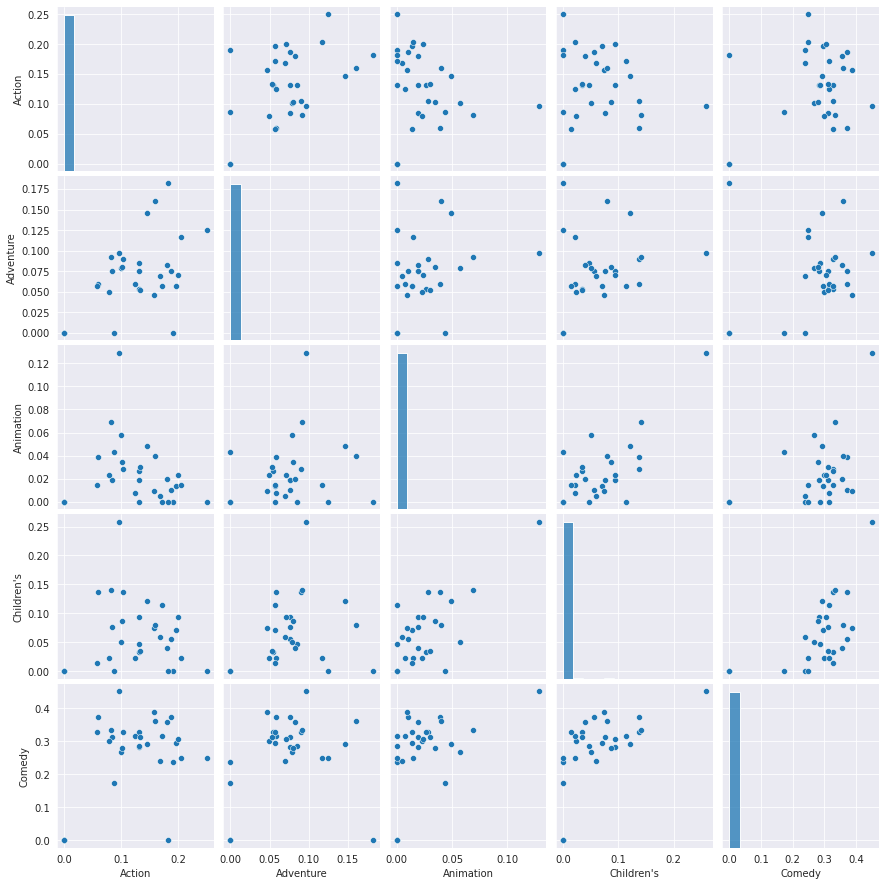

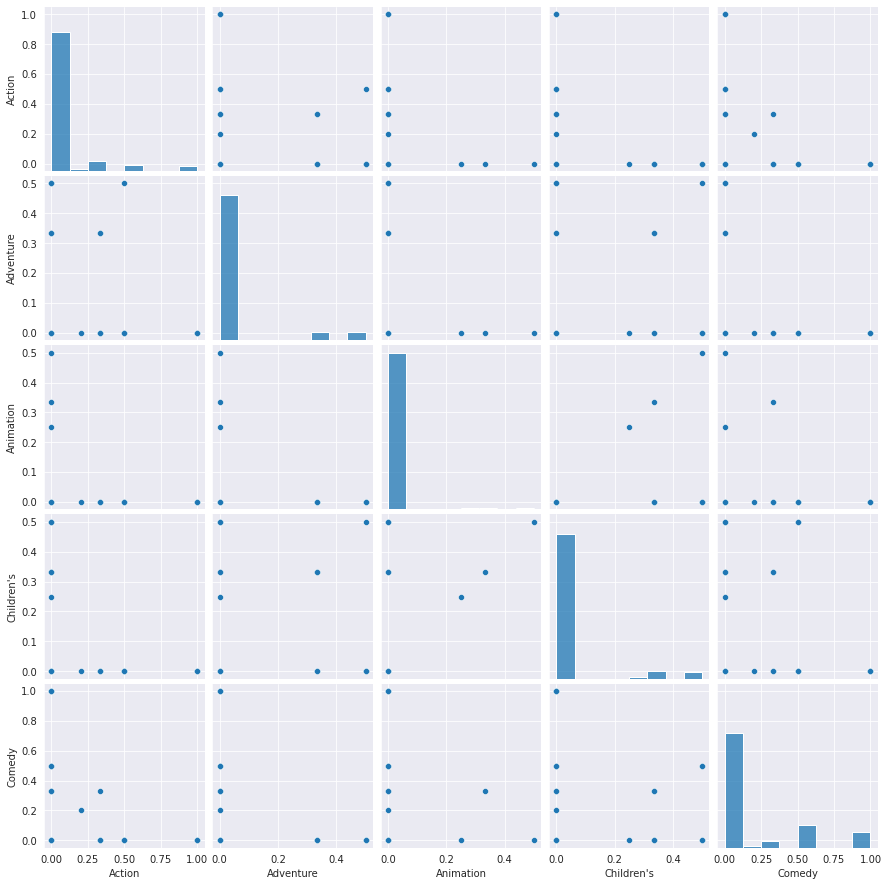

In [97]:
sns.pairplot(ratings.iloc[:,:5])
sns.pairplot(movies2.iloc[:100,:5])

Al comparar las posiciones de diferentes usuarios y de las peliculas notamos que en realidad este modelo de recomendación no es muy bueno, ya que por lo general las peliculas tienen pocos géneros entonces estas suelen estar a las orillas del espacio, mientras los usuarios suelen ver más peliculas de distintos tipos por lo que no van a soler estar en las orillas.

In [107]:
#entrenamos nuestro modelo con knn y la base de datos de las peliculas
neigh = KNeighborsClassifier(n_neighbors=4)
neigh.fit(movies2,movies2.index)

KNeighborsClassifier(n_neighbors=4)

In [108]:
def recomnedación(id):
  '''
  input: id=id del usuario 
  output: la pelicula que le recomienda el modelo
  '''
  print('Dados tus gustos la pelicula que te recomendamos es:',neigh.predict((ratings.iloc[id-1].to_frame().T)))

In [109]:
recomnedación(0)

Dados tus gustos la pelicula que te recomendamos es: ['Diva (1981)']


# Algoritmo 2
Ahora debido a que digimos que el modelo anterior no era el más optimo vamos a hacerlo de otra manera

In [19]:
"""Entrenar el modelo"""
from surprise.model_selection import train_test_split
from surprise import accuracy

reader = Reader()
data = Dataset.load_from_df(mov, reader) #Traemos la base de datos completa

trainset, testset = train_test_split(data, test_size=.25)
svd = SVD() #definición del modelo
trainset = data.build_full_trainset()
svd.fit(trainset) #training

print("Rendimiento sobre conjunto de prueba")
predictions = svd.test(testset)
print(accuracy.rmse(predictions))


Rendimiento sobre conjunto de prueba
RMSE: 0.6713
0.6712807890774011


In [123]:
def recomendacion(id,movies=movies):
  

  movies['Estimate_Score'] = movies['movie_id'].apply(lambda x: svd.predict(id, x).est)
  movies = movies.sort_values('Estimate_Score', ascending=False)
  print('Te recomendamos las siguientes peliculas')
  return(movies.head(10))

In [126]:
recomendacion(760)

Te recomendamos las siguientes peliculas


,movie_id,title,genres,totgen,Estimate_Score
1162,1178,Paths of Glory (1957),"[Drama, War]",2,5.000000
1203,1221,"Godfather: Part II, The (1974)","[Action, Crime, Drama]",3,5.000000
2789,2858,American Beauty (1999),"[Comedy, Drama]",2,5.000000
847,858,"Godfather, The (1972)","[Action, Crime, Drama]",3,5.000000
1211,1230,Annie Hall (1977),"[Comedy, Romance]",2,4.995562
662,668,Pather Panchali (1955),[Drama],1,4.979277
1227,1247,"Graduate, The (1967)","[Drama, Romance]",2,4.962391
3022,3091,Kagemusha (1980),"[Drama, War]",2,4.960335
910,922,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),[Film-Noir],1,4.955570
2836,2905,Sanjuro (1962),"[Action, Adventure]",2,4.954278


In [125]:
recomendacion(0)

Te recomendamos las siguientes peliculas


,movie_id,title,genres,totgen,Estimate_Score
2890,2959,Fight Club (1999),[Drama],1,4.947182
3091,3160,Magnolia (1999),[Drama],1,4.673812
293,296,Pulp Fiction (1994),"[Crime, Drama]",2,4.610488
847,858,"Godfather, The (1972)","[Action, Crime, Drama]",3,4.582760
2789,2858,American Beauty (1999),"[Comedy, Drama]",2,4.561532
1950,2019,Seven Samurai (The Magnificent Seven) (Shichin...,"[Action, Drama]",2,4.531647
2836,2905,Sanjuro (1962),"[Action, Adventure]",2,4.528836
1162,1178,Paths of Glory (1957),"[Drama, War]",2,4.521857
2291,2360,"Celebration, The (Festen) (1998)",[Drama],1,4.501973
2260,2329,American History X (1998),[Drama],1,4.498543
